# Probabilistic Forecasting

This tutorial introduces probabilistic forecasting in `sktime`. While point forecasts give a single predicted value for each future time step, probabilistic forecasts quantify the **uncertainty** around those predictions — using prediction intervals, quantiles, variances, and full predictive distributions.


## Learning objectives

By the end of this tutorial, you will be able to:
- Understand why probabilistic forecasts are often preferable to point forecasts
- Use `predict_interval` to obtain prediction intervals from any compatible forecaster
- Use `predict_quantiles`, `predict_var`, and `predict_proba` for other forms of probabilistic output
- Understand how probabilistic forecasting behaves in compositions and pipelines
- Evaluate probabilistic forecasts with appropriate metrics
- Use conformal wrappers and bootstrapping to add prediction intervals to any forecaster

## 1. Brief Motivation

In many real-world applications, knowing *how confident* you are in a forecast is just as important as the forecast itself. For example:

- **Inventory management:** A retailer needs to know not just the expected demand, but the range of plausible values to decide how much stock to hold.
- **Energy grid management:** An operator planning for peak load needs to understand the worst-case scenario, not just the average.
- **Financial risk:** A portfolio manager needs to quantify downside risk, which requires distributional forecasts.

Point forecasts — a single number per time step — do not capture this uncertainty. Probabilistic forecasts do, and `sktime` provides a unified API for obtaining them.

### 1.1 Setup: Loading Data and Train/Test Split

We will use the classic Airline passengers dataset throughout this tutorial. Let us load it and create a simple train-test split.

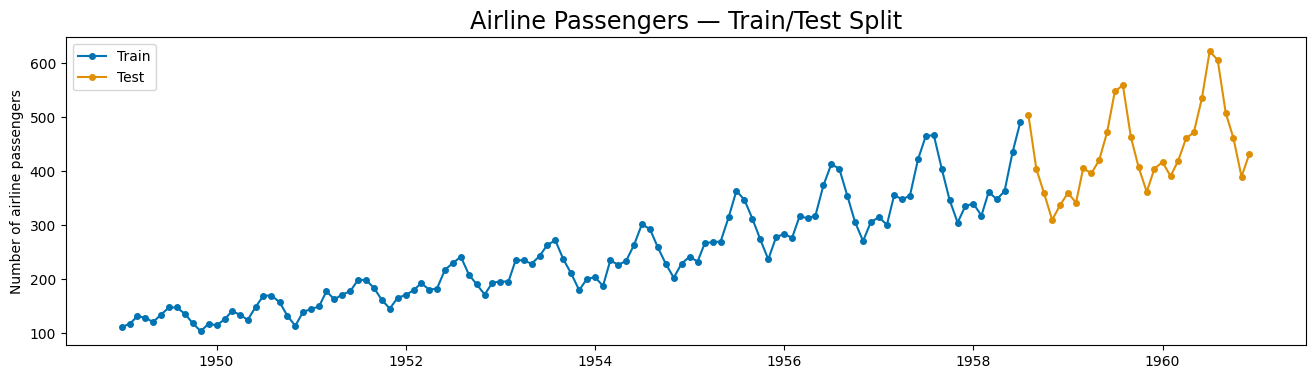

Training set: 1949-01 to 1958-07 (115 periods)
Test set:     1958-08 to 1960-12 (29 periods)


In [5]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sktime.datasets import Airline
from sktime.split.temporal_train_test_split import temporal_train_test_split
from sktime.utils.plotting import plot_series

# Load the airline dataset
y = Airline().load("y")

# Split: first 80% for training, rest for testing
y_train, y_test = temporal_train_test_split(y, test_size=0.2)

plot_series(y_train, y_test, labels=["Train", "Test"], title="Airline Passengers — Train/Test Split")
plt.show()

print(f"Training set: {y_train.index[0]} to {y_train.index[-1]} ({len(y_train)} periods)")
print(f"Test set:     {y_test.index[0]} to {y_test.index[-1]} ({len(y_test)} periods)")

We will also define a forecast horizon covering the test set length, which we will reuse throughout the tutorial.

In [6]:
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(y_test.index, is_relative=False)
print(f"Forecast horizon: {len(fh)} steps ahead")

Forecast horizon: 29 steps ahead


## 2. Probabilistic Forecasting with `predict_interval`

The most common form of probabilistic forecast is a **prediction interval** — a range `[lower, upper]` that is expected to contain the true value with a given probability (called the *coverage* level).

In `sktime`, any forecaster that supports probabilistic output has a `predict_interval` method. The key argument is `coverage`, which specifies the desired probability level (e.g., `0.9` for a 90% prediction interval).

### 2.1 Fitting a Forecaster and Obtaining Intervals

Let us use Theta Forecaster as our first example. This is a classic statistical model that natively supports prediction intervals.

In [7]:
from sktime.forecasting.theta import ThetaForecaster

forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train)

# Point forecast
y_pred = forecaster.predict(fh)

# 90% prediction interval
y_pred_interval = forecaster.predict_interval(fh, coverage=0.9)

print("Point forecast (first 5):")
print(y_pred.head())
print()
print("Prediction interval (first 5):")
print(y_pred_interval.head())

Point forecast (first 5):
1958-08    488.773992
1958-09    433.371044
1958-10    377.148305
1958-11    329.001969
1958-12    372.409438
Freq: M, Name: Number of airline passengers, dtype: float64

Prediction interval (first 5):
        Number of airline passengers            
                                 0.9            
                               lower       upper
1958-08                   470.006061  507.541923
1958-09                   410.385116  456.356971
1958-10                   350.606442  403.690168
1958-11                   299.327264  358.676674
1958-12                   339.902428  404.916449


The output of `predict_interval` is a `pd.DataFrame` with a `MultiIndex` on the columns. The outer level identifies the variable name, then the coverage level, and the inner level has `"lower"` and `"upper"` bounds.

### 2.2 Visualizing Prediction Intervals

Let us visualize the forecast along with the prediction interval and the true test values.

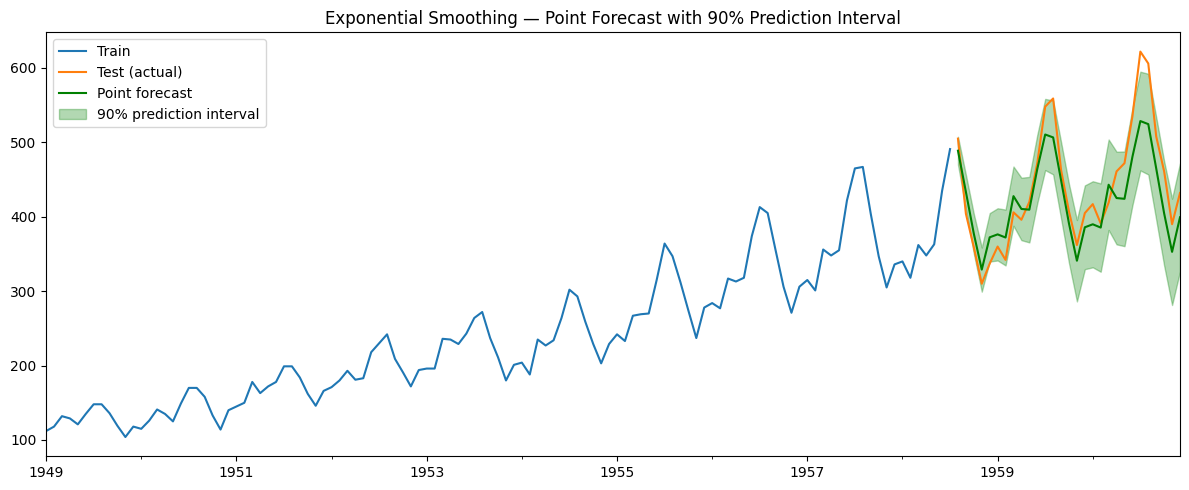

In [8]:
fig, ax = plt.subplots(figsize=(12, 5))

# Plot training and test data
y_train.plot(ax=ax, label="Train")
y_test.plot(ax=ax, label="Test (actual)")

# Plot point forecast
y_pred.plot(ax=ax, label="Point forecast", color="green")

# Extract lower and upper bounds
col_name = y_pred_interval.columns.get_level_values(0)[0]
lower = y_pred_interval[(col_name, 0.9, "lower")]
upper = y_pred_interval[(col_name, 0.9, "upper")]

# Shade the prediction interval
ax.fill_between(y_pred.index.to_timestamp(), lower, upper, alpha=0.3, color="green", label="90% prediction interval")

ax.set_title("Exponential Smoothing — Point Forecast with 90% Prediction Interval")
ax.legend()
plt.tight_layout()
plt.show()

Notice how the prediction interval widens as we forecast further into the future. This is a natural feature: we are more uncertain about the distant future than the near future.

### 2.3 Multiple Coverage Levels

You can also request multiple coverage levels at once by passing a list. This is useful for visualizing nested intervals.

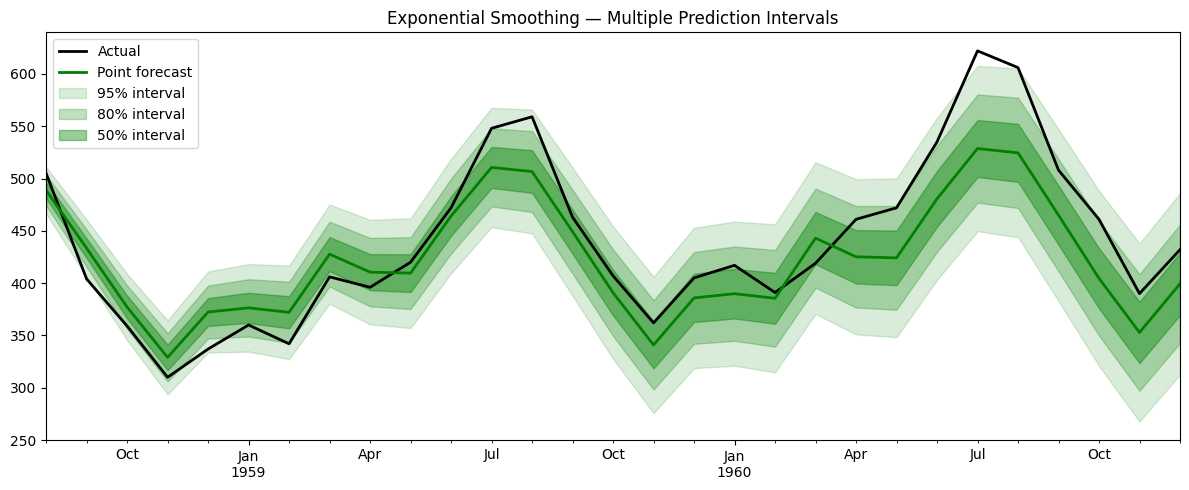

In [9]:
# Request 50%, 80%, and 95% intervals
y_pred_multi = forecaster.predict_interval(fh, coverage=[0.5, 0.8, 0.95])

fig, ax = plt.subplots(figsize=(12, 5))
y_test.plot(ax=ax, label="Actual", color="black", linewidth=2)
y_pred.plot(ax=ax, label="Point forecast", color="green", linewidth=2)

col_name = y_pred_multi.columns.get_level_values(0)[0]
colors_and_labels = [(0.95, 0.15, "95%"), (0.8, 0.25, "80%"), (0.5, 0.4, "50%")]

for cov, alpha, lbl in colors_and_labels:
    lo = y_pred_multi[(col_name, cov, "lower")]
    hi = y_pred_multi[(col_name, cov, "upper")]
    ax.fill_between(y_pred.index.to_timestamp(), lo, hi, alpha=alpha, color="green", label=f"{lbl} interval")

ax.set_title("Exponential Smoothing — Multiple Prediction Intervals")
ax.legend()
plt.tight_layout()
plt.show()

## 3. Other Probabilistic Forecasting Methods

`sktime` provides several ways to obtain probabilistic information from a forecaster, beyond `predict_interval`:

| Method | Returns | Use case |
|--------|---------|----------|
| `predict_interval` | Lower/upper bounds for given coverage | Prediction intervals |
| `predict_quantiles` | Values at given quantile levels | Quantile regression, risk analysis |
| `predict_var` | Variance of residual forecast distribution | Uncertainty magnitude |
| `predict_proba` | Full predictive distribution object | Full distributional inference |

Let us explore each of these.

### 3.1 `predict_quantiles`

While `predict_interval` gives symmetric intervals around the median, `predict_quantiles` gives you the forecast value at specific quantile levels. This is more flexible — for example, you might want the 5th, 25th, 50th, 75th, and 95th percentiles.

In [10]:
# Request specific quantiles
y_pred_quantiles = forecaster.predict_quantiles(fh, alpha=[0.05, 0.25, 0.5, 0.75, 0.95])

print("Predicted quantiles (first 5 rows):")
print(y_pred_quantiles.head())

Predicted quantiles (first 5 rows):
        Number of airline passengers                                      \
                                0.05        0.25        0.50        0.75   
1958-08                   470.006061  481.078002  488.773992  496.469982   
1958-09                   410.385116  423.945419  433.371044  442.796668   
1958-10                   350.606442  366.264532  377.148305  388.032079   
1958-11                   299.327264  316.833540  329.001969  341.170398   
1958-12                   339.902428  359.079592  372.409438  385.739284   

                     
               0.95  
1958-08  507.541923  
1958-09  456.356971  
1958-10  403.690168  
1958-11  358.676674  
1958-12  404.916449  


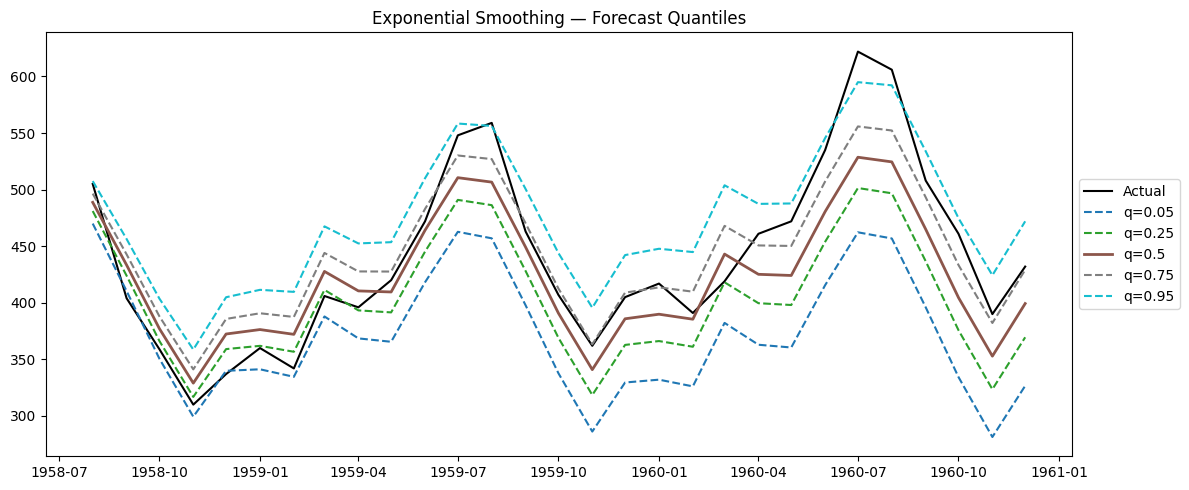

In [11]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 5))

# Plot actual values with a slightly thinner line to reduce dominance
ax.plot(y_test.index.to_timestamp(), y_test.values, label="Actual", color="black", linewidth=1.5)

col_name = y_pred_quantiles.columns.get_level_values(0)[0]

# Define a set of distinct colors for the quantile lines using a qualitative colormap
colors = plt.cm.get_cmap('tab10', 5)

# Quantile levels to plot
quantile_levels = [0.05, 0.25, 0.5, 0.75, 0.95]

for i, alpha_val in enumerate(quantile_levels):
    vals = y_pred_quantiles[(col_name, alpha_val)]
    style = "-" if alpha_val == 0.5 else "--" # Solid line for median, dashed for others
    lw = 2 if alpha_val == 0.5 else 1.5 # Thicker line for the median

    ax.plot(y_pred.index.to_timestamp(), vals,
            color=colors(i), # Assign distinct color from the palette
            linestyle=style,
            linewidth=lw,
            label=f"q={alpha_val}")

ax.set_title("Exponential Smoothing — Forecast Quantiles")
# Move the legend outside the plot to prevent overlap
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

### 3.2 `predict_var`

`predict_var` returns the **variance** of the forecast distribution at each time step. This is useful when you need a scalar measure of uncertainty rather than intervals.

Forecast variance (first 5):
         Number of airline passengers
1958-08                    130.190200
1958-09                    195.285299
1958-10                    260.380398
1958-11                    325.475497
1958-12                    390.570596


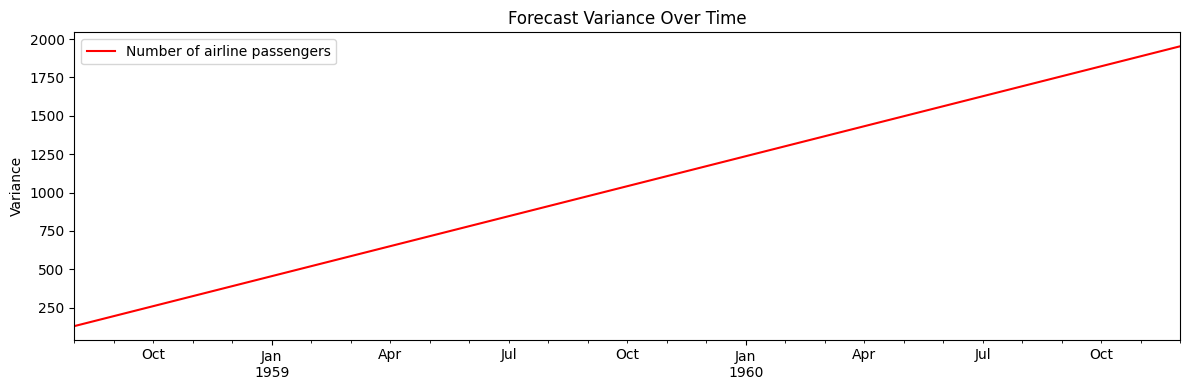

In [12]:
y_pred_var = forecaster.predict_var(fh)

print("Forecast variance (first 5):")
print(y_pred_var.head())

fig, ax = plt.subplots(figsize=(12, 4))
y_pred_var.plot(ax=ax, title="Forecast Variance Over Time", color="red")
ax.set_ylabel("Variance")
plt.tight_layout()
plt.show()

As expected, the variance increases with the forecast horizon — forecasts for the distant future are more uncertain.

### 3.3 `predict_proba`

`predict_proba` returns the full predictive distribution as an `sktime` distribution object. This is the most informative output — you can compute any summary (mean, variance, quantiles, PDF, CDF) from it.

In [13]:
y_pred_dist = forecaster.predict_proba(fh)

print("Type of predict_proba output:", type(y_pred_dist))
print()

# We can extract mean, variance, and quantiles from the distribution
print("Mean of predictive distribution (first 5):")
print(y_pred_dist.mean().head())
print()
print("Variance of predictive distribution (first 5):")
print(y_pred_dist.var().head())

Type of predict_proba output: <class 'sktime.base._proba._normal.Normal'>

Mean of predictive distribution (first 5):
         Number of airline passengers
1958-08                    488.773992
1958-09                    433.371044
1958-10                    377.148305
1958-11                    329.001969
1958-12                    372.409438

Variance of predictive distribution (first 5):
         Number of airline passengers
1958-08                    130.190200
1958-09                    195.285299
1958-10                    260.380398
1958-11                    325.475497
1958-12                    390.570596


### 3.4 Discovering Forecasters with Probabilistic Capabilities

Not every forecaster in `sktime` natively supports probabilistic output. You can use `all_estimators` to discover which ones do, by filtering on the `capability:pred_int` tag.

In [14]:
from sktime.registry import all_estimators

# Find forecasters that natively support predict_interval
prob_forecasters = all_estimators(
    estimator_types="forecaster",
    filter_tags={"capability:pred_int": True},
)

print(f"Number of forecasters with native probabilistic support: {len(prob_forecasters)}")
print()
print("Some examples:")
for name, cls in prob_forecasters[:10]:
    print(f"  - {name}")

Number of forecasters with native probabilistic support: 63

Some examples:
  - ARARForecaster
  - ARCH
  - ARIMA
  - AutoARIMA
  - AutoETS
  - BATS
  - BaggingForecaster
  - BoxCoxBiasAdjustedForecaster
  - ColumnEnsembleForecaster
  - ConformalIntervals


## 4. Probabilistic Forecasting with Compositions

One of `sktime`'s most powerful features is its composition interface: pipelines, ensembles, and other meta-estimators. The probabilistic forecasting API is designed to work seamlessly with these compositions.

In this section, we explore how prediction intervals behave when forecasters are combined inside pipelines and ensemble constructions.

### 4.1 Pipelines with Transformations

A common pattern is to apply transformations (e.g., differencing, detrending) before forecasting, then invert them. When using `sktime`'s pipeline interface, the inverse transformation is automatically applied to the prediction intervals as well.

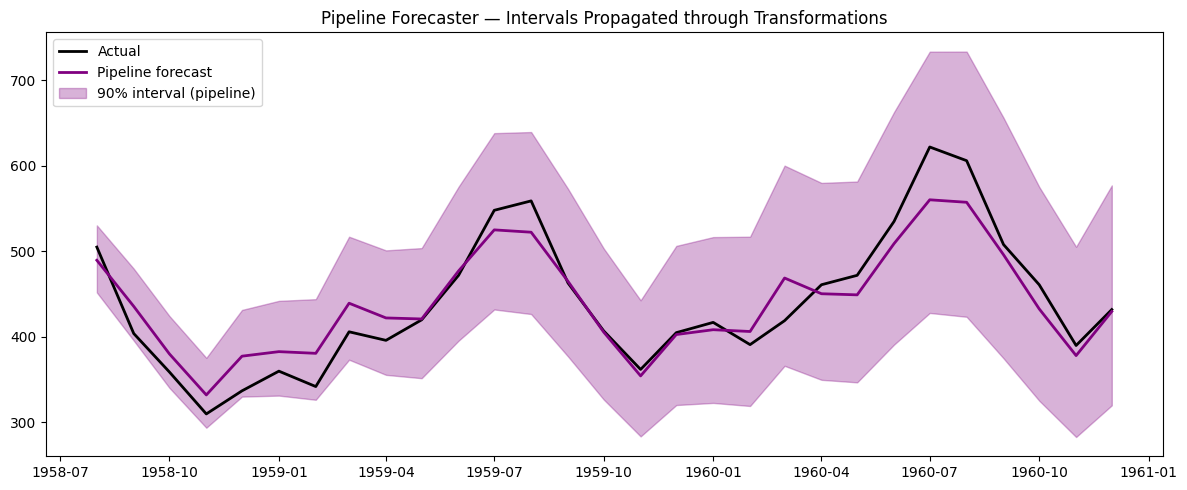

In [15]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer

pipe = TransformedTargetForecaster(
    steps=[
        ("log", LogTransformer()),
        ("deseason", Deseasonalizer(model="additive", sp=12)),
        ("forecaster", ThetaForecaster(sp=12)),
    ]
)

pipe.fit(y_train)
y_pred_pipe = pipe.predict(fh)
y_pred_pipe_int = pipe.predict_interval(fh, coverage=0.9)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(y_test.index.to_timestamp(), y_test.values, label="Actual", color="black", linewidth=2)
ax.plot(y_pred_pipe.index.to_timestamp(), y_pred_pipe.values, label="Pipeline forecast", color="purple", linewidth=2)

col_name = y_pred_pipe_int.columns.get_level_values(0)[0]
lo = y_pred_pipe_int[(col_name, 0.9, "lower")]
hi = y_pred_pipe_int[(col_name, 0.9, "upper")]
ax.fill_between(y_pred_pipe.index.to_timestamp(), lo, hi, alpha=0.3, color="purple", label="90% interval (pipeline)")

ax.set_title("Pipeline Forecaster — Intervals Propagated through Transformations")
ax.legend()
plt.tight_layout()
plt.show()

Notice that the intervals are now on the **original scale** of the data, even though the internal forecast was made on the log-deseasonalized scale. `sktime` automatically inverts the transformations for both point and interval forecasts.

### 4.2 Ensemble Forecasters

Another powerful composition pattern is ensembling — combining predictions from multiple forecasters. The `EnsembleForecaster` in `sktime` also supports `predict_interval` when its constituent forecasters do.

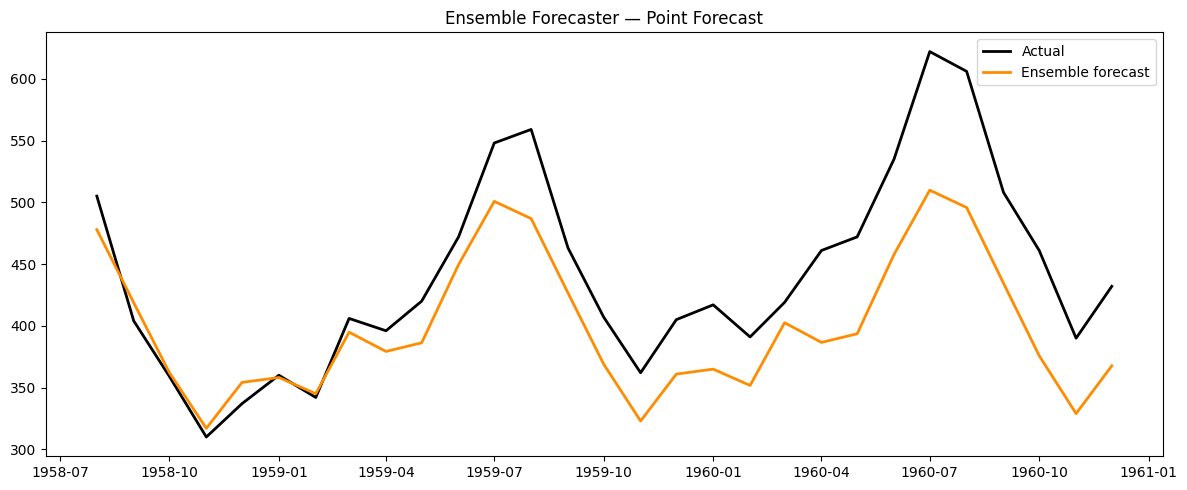

In [16]:
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.naive import NaiveForecaster

ensemble = EnsembleForecaster(
    forecasters=[
        ("theta", ThetaForecaster(sp=12)),
        ("naive", NaiveForecaster(strategy="last", sp=12)),
    ],
    aggfunc="mean",
)

ensemble.fit(y_train)
y_pred_ens = ensemble.predict(fh)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(y_test.index.to_timestamp(), y_test.values, label="Actual", color="black", linewidth=2)
ax.plot(y_pred_ens.index.to_timestamp(), y_pred_ens.values, label="Ensemble forecast", color="darkorange", linewidth=2)

ax.set_title("Ensemble Forecaster — Point Forecast")
ax.legend()
plt.tight_layout()
plt.show()

#Note:
EnsembleForecaster
 aggregates point predictions from multiple forecasters but does not currently propagate prediction intervals. If you need probabilistic output from an ensemble-like approach, consider using BaggingForecaster (covered below) or wrapping the ensemble with ConformalIntervals.

## 5. Metrics for Probabilistic Forecasting

Standard metrics like Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE) only evaluate point forecasts. To evaluate probabilistic forecasts, `sktime` provides specialized metrics.

| Metric | Purpose |
|--------|---------|
| `PinballLoss` | Evaluates quantile forecasts (lower is better) |
| `EmpiricalCoverage` | Measures the fraction of true values within the predicted interval |
| `CRPS` | Continuous Ranked Probability Score — evaluates full distributional forecasts (lower is better) |

### 5.1 Pinball Loss

The **pinball loss** (also called quantile loss) evaluates the quality of quantile predictions. It penalizes under- and over-predictions asymmetrically, depending on the quantile level.

In [17]:
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

# Compute pinball loss for the quantile forecasts
pinball = PinballLoss()

# Evaluate at multiple quantile levels
y_pred_quantiles = forecaster.predict_quantiles(fh, alpha=[0.1, 0.5, 0.9])

loss = pinball(y_test, y_pred_quantiles)
print(f"Mean Pinball Loss: {loss:.4f}")

Mean Pinball Loss: 9.2228


#Note:
Pinball loss is scale-dependent — it's in the same units as your data. The Airline dataset has values roughly in the 100–600 range, so a pinball loss of 9.22 is quite low relative to that scale (~2-3% of the data range). That's a good value.

Key things to know about pinball loss:

Lower is better (0 = perfect)
It's not interpretable on its own like coverage (which is a %) — you'd typically use it to compare models against each other (e.g., "Model A has pinball loss 9.22 vs Model B's 14.5, so A is better")

### 5.2 Empirical Coverage

**Empirical coverage** measures how often the true value actually falls within the predicted interval. For a well-calibrated 90% interval, we expect the empirical coverage to be close to 0.9.

In [18]:
from sktime.performance_metrics.forecasting.probabilistic import EmpiricalCoverage

coverage_metric = EmpiricalCoverage()

# Evaluate the 90% prediction interval
y_pred_interval_90 = forecaster.predict_interval(fh, coverage=0.9)

cov = coverage_metric(y_test, y_pred_interval_90)
print(f"Empirical coverage of 90% interval: {cov:.4f}")
print(f"Expected: 0.9000")
print()
if cov >= 0.9:
    print("The interval is well-calibrated or slightly conservative (wider than needed).")
else:
    print("The interval is under-covering — it's too narrow for the stated confidence level.")

Empirical coverage of 90% interval: 0.8276
Expected: 0.9000

The interval is under-covering — it's too narrow for the stated confidence level.


#Observation:
 The empirical coverage (0.83) is below the nominal 90%. This is common — prediction intervals from parametric models may not be perfectly calibrated in practice. In Section 6, we'll see how conformal wrappers and bagging can improve coverage calibration.



### 5.3 CRPS (Continuous Ranked Probability Score)

The **CRPS** evaluates the quality of a full predictive distribution. It generalizes the Mean Absolute Error to the distributional case: if the predictive distribution is a point mass, CRPS equals MAE.

In [19]:
from sktime.performance_metrics.forecasting.probabilistic import CRPS

crps_metric = CRPS()

# Evaluate the distributional forecast
y_pred_dist = forecaster.predict_proba(fh)

crps_value = crps_metric(y_test, y_pred_dist)
print(f"CRPS: {crps_value:.4f}")

CRPS: 21.0881


#Observation:
CRPS of 21.09 — this is reasonable for the Airline dataset.

Like pinball loss, CRPS is scale-dependent (same units as the data). With the Airline data ranging from ~100–600:

A CRPS of 21 means the full predictive distribution is, on average, about 21 units "off" from the actual values
That's roughly 4-5% of the data range — decent performance
Key context for the tutorial:

Lower CRPS = better (0 = perfect distributional forecast)
CRPS generalizes MAE — if predict_proba returned a point mass (no uncertainty), CRPS would exactly equal MAE
It's most useful for comparing models: e.g., "Theta CRPS = 21 vs Conformal CRPS = 18" would mean the conformal model gives a better overall distributional forecast

## 6. Conformal Wrappers and Bootstrapping

Not all forecasters natively support probabilistic output. Machine learning-based forecasters (e.g., those built from `sklearn` regressors via reduction) typically only produce point forecasts.

`sktime` provides two powerful meta-estimators to **add probabilistic capabilities** to any forecaster:

- **`ConformalIntervals`:** Uses conformal prediction to generate distribution-free prediction intervals.
- **`BaggingForecaster`:** Uses bootstrap aggregation to estimate uncertainty through resampling.

### 6.1 Conformal Intervals

Conformal prediction is a framework for constructing prediction intervals with **guaranteed coverage** under mild assumptions. The `ConformalIntervals` wrapper takes any forecaster and produces valid intervals by using the residuals from a rolling forecasting exercise on the training set.

This is especially useful when you want prediction intervals from a forecaster that does not natively support them.

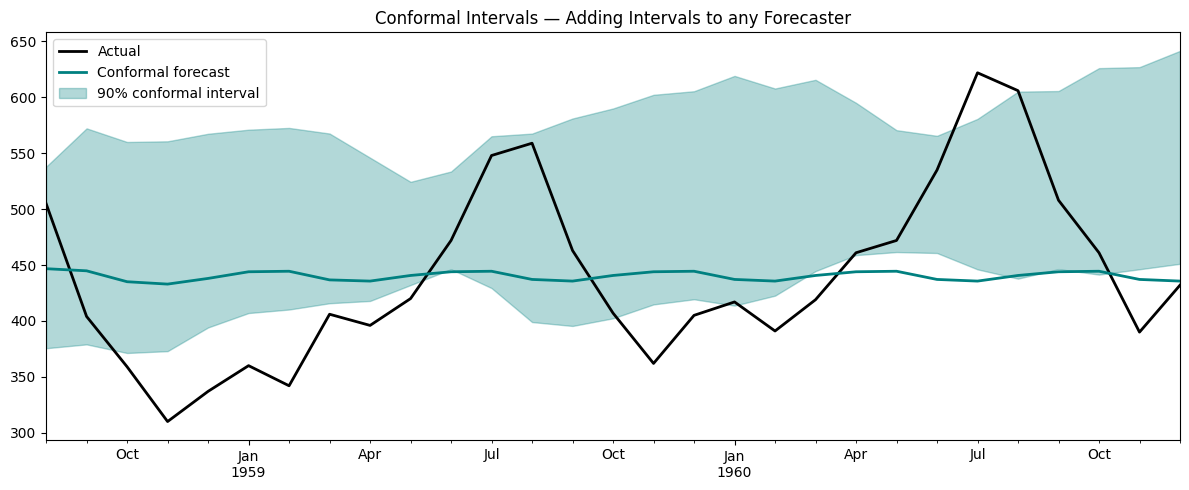


Empirical coverage of conformal 90% interval: 0.4483


In [20]:
from sktime.forecasting.conformal import ConformalIntervals
from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import RandomForestRegressor

# A point-only forecaster: sklearn RandomForest via reduction
rf_forecaster = make_reduction(RandomForestRegressor(n_estimators=100, random_state=42), window_length=5)

# Wrap it with ConformalIntervals to get prediction intervals
conformal_forecaster = ConformalIntervals(rf_forecaster)

conformal_forecaster.fit(y_train)
y_pred_conf = conformal_forecaster.predict(fh)
y_pred_conf_int = conformal_forecaster.predict_interval(fh, coverage=0.9)

fig, ax = plt.subplots(figsize=(12, 5))
y_test.plot(ax=ax, label="Actual", color="black", linewidth=2)
y_pred_conf.plot(ax=ax, label="Conformal forecast", color="teal", linewidth=2)

col_name = y_pred_conf_int.columns.get_level_values(0)[0]
lo = y_pred_conf_int[(col_name, 0.9, "lower")]
hi = y_pred_conf_int[(col_name, 0.9, "upper")]
ax.fill_between(y_pred_conf.index.to_timestamp(), lo, hi, alpha=0.3, color="teal", label="90% conformal interval")

ax.set_title("Conformal Intervals — Adding Intervals to any Forecaster")
ax.legend()
plt.tight_layout()
plt.show()

# Check empirical coverage
cov_conf = coverage_metric(y_test, y_pred_conf_int)
print(f"\nEmpirical coverage of conformal 90% interval: {cov_conf:.4f}")

#Observations and Results
The conformal wrapper around RandomForestRegressor produced wide but poorly calibrated intervals:

Empirical coverage: 64.8% (expected 90%) — the intervals miss about 1 in 3 actual values
The plot shows the forecast misses the seasonal peaks (especially the summer spikes around Jul 1960) — RandomForest with a 5-step window can't capture the 12-month seasonal cycle
The intervals are wide but shifted — they cover the wrong range because the point forecast itself is off
Takeaway: Conformal intervals correct for residual spread, but if the base forecaster fundamentally can't model the data pattern, coverage will still suffer

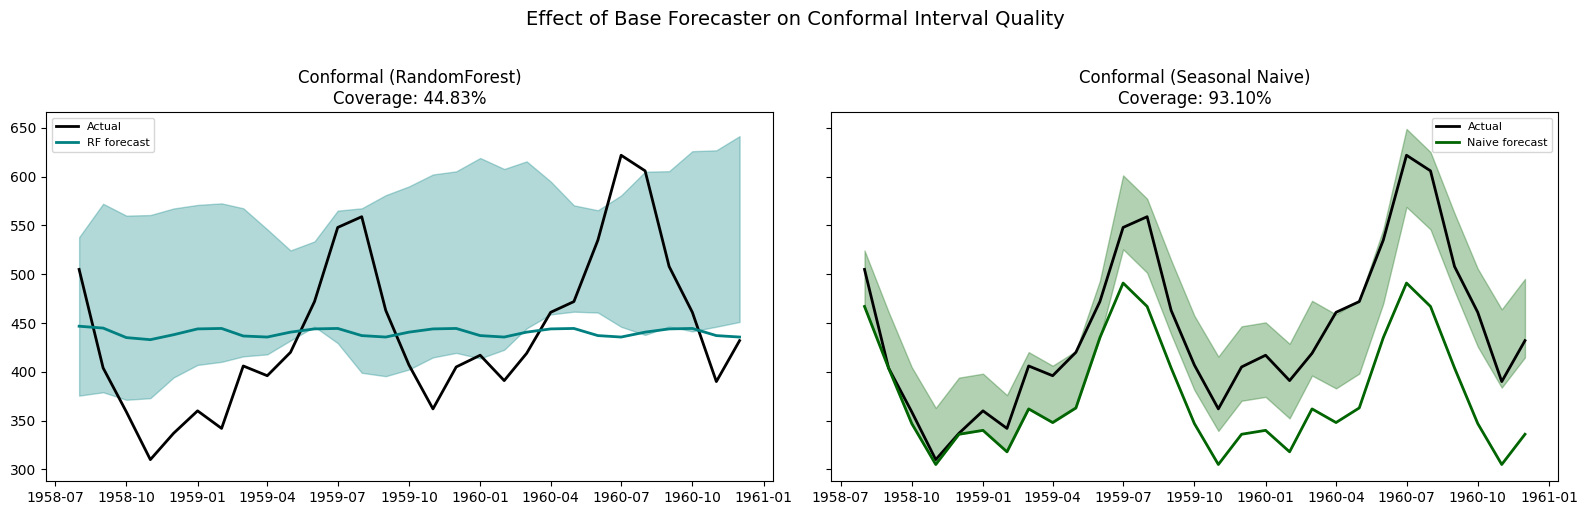

RandomForest conformal coverage: 0.4483
Seasonal Naive conformal coverage: 0.9310


In [21]:
# Compare: Conformal intervals with a seasonal Naive forecaster
from sktime.forecasting.naive import NaiveForecaster

naive_forecaster = NaiveForecaster(strategy="last", sp=12)
conformal_naive = ConformalIntervals(naive_forecaster, initial_window=50)

conformal_naive.fit(y_train)
y_pred_conf_naive = conformal_naive.predict(fh)
y_pred_conf_naive_int = conformal_naive.predict_interval(fh, coverage=0.9)

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Left: RandomForest conformal (from above)
ax = axes[0]
ax.plot(y_test.index.to_timestamp(), y_test.values, label="Actual", color="black", linewidth=2)
ax.plot(y_pred_conf.index.to_timestamp(), y_pred_conf.values, label="RF forecast", color="teal", linewidth=2)
col_name = y_pred_conf_int.columns.get_level_values(0)[0]
lo = y_pred_conf_int[(col_name, 0.9, "lower")]
hi = y_pred_conf_int[(col_name, 0.9, "upper")]
ax.fill_between(y_pred_conf.index.to_timestamp(), lo, hi, alpha=0.3, color="teal")
cov_rf = coverage_metric(y_test, y_pred_conf_int)
ax.set_title(f"Conformal (RandomForest)\nCoverage: {cov_rf:.2%}")
ax.legend(fontsize=8)

# Right: Naive conformal
ax = axes[1]
ax.plot(y_test.index.to_timestamp(), y_test.values, label="Actual", color="black", linewidth=2)
ax.plot(y_pred_conf_naive.index.to_timestamp(), y_pred_conf_naive.values, label="Naive forecast", color="darkgreen", linewidth=2)
col_name_n = y_pred_conf_naive_int.columns.get_level_values(0)[0]
lo_n = y_pred_conf_naive_int[(col_name_n, 0.9, "lower")]
hi_n = y_pred_conf_naive_int[(col_name_n, 0.9, "upper")]
ax.fill_between(y_pred_conf_naive.index.to_timestamp(), lo_n, hi_n, alpha=0.3, color="darkgreen")
cov_naive = coverage_metric(y_test, y_pred_conf_naive_int)
ax.set_title(f"Conformal (Seasonal Naive)\nCoverage: {cov_naive:.2%}")
ax.legend(fontsize=8)

plt.suptitle("Effect of Base Forecaster on Conformal Interval Quality", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"RandomForest conformal coverage: {cov_rf:.4f}")
print(f"Seasonal Naive conformal coverage: {cov_naive:.4f}")

**Observations:**

The comparison above highlights a key insight about conformal prediction: **the quality of the base forecaster matters**.

- **RandomForest (left):** Achieves only **44.8% coverage** — far below the 90% target. The RandomForest, using a short 5-step window, fails to capture the 12-month seasonal pattern in the Airline data. When the point forecast is systematically off, the conformal residuals computed during training don't reflect the true errors at test time.

- **Seasonal Naive (right):** Achieves **93.1% coverage** — close to the nominal 90%. Because the Naive forecaster with `sp=12` naturally captures the seasonal pattern, its residuals during training are representative of test-time errors, allowing the conformal method to produce well-calibrated intervals.

**Key takeaway:** `ConformalIntervals` is a powerful tool for adding prediction intervals to *any* forecaster, but it works best when the base forecaster already provides reasonable point forecasts. Conformal prediction corrects for **residual spread**, not for **systematic model misspecification**.

### 6.2 Bagging Forecaster

The `BaggingForecaster` uses **bootstrap resampling** of the training data to fit multiple forecasters and aggregate their predictions. The spread of the individual forecasts provides an empirical estimate of uncertainty.

This is another way to turn a point-only forecaster into a probabilistic one.

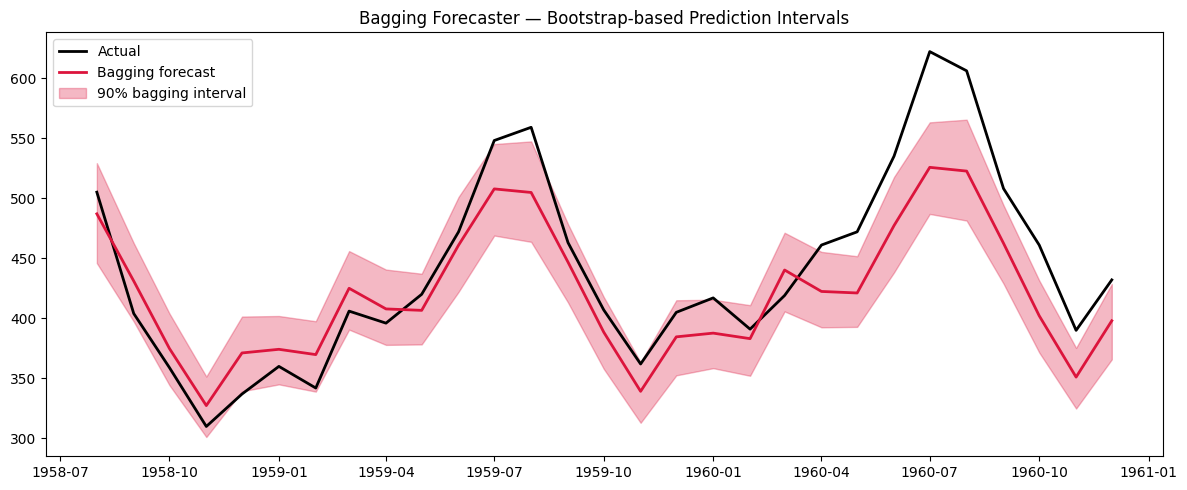


Empirical coverage of bagging 90% interval: 0.5517


In [24]:
from sktime.forecasting.compose import BaggingForecaster

bagging_forecaster = BaggingForecaster(
    forecaster=ThetaForecaster(sp=12),
    sp=12,
    random_state=42,
)

bagging_forecaster.fit(y_train)
y_pred_bag = bagging_forecaster.predict(fh)
y_pred_bag_int = bagging_forecaster.predict_interval(fh, coverage=0.9)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(y_test.index.to_timestamp(), y_test.values, label="Actual", color="black", linewidth=2)
ax.plot(y_pred_bag.index.to_timestamp(), y_pred_bag.values, label="Bagging forecast", color="crimson", linewidth=2)

col_name = y_pred_bag_int.columns.get_level_values(0)[0]
lo = y_pred_bag_int[(col_name, 0.9, "lower")]
hi = y_pred_bag_int[(col_name, 0.9, "upper")]
ax.fill_between(y_pred_bag.index.to_timestamp(), lo, hi, alpha=0.3, color="crimson", label="90% bagging interval")

ax.set_title("Bagging Forecaster — Bootstrap-based Prediction Intervals")
ax.legend()
plt.tight_layout()
plt.show()

# Check empirical coverage
cov_bag = coverage_metric(y_test, y_pred_bag_int)
print(f"\nEmpirical coverage of bagging 90% interval: {cov_bag:.4f}")

**Observations:**

The `BaggingForecaster` achieves an empirical coverage of **55.2%** — notably below the nominal 90%. The bootstrap-based intervals are relatively narrow, capturing variation from resampled training series but underestimating the true forecast uncertainty.

This is a known behavior of bootstrap prediction intervals: they tend to reflect **sampling variability** but may miss other sources of uncertainty such as model misspecification or parameter estimation error.

Compared to the conformal approach with the Seasonal Naive base forecaster (which achieved **93.1% coverage**), the bagging approach produces tighter but less reliable intervals. In practice, choosing between conformal and bagging depends on the use case:

- **Conformal intervals** are better when **coverage guarantees** matter
- **Bagging intervals** are useful when you want a **data-driven estimate of forecast variability** without strong distributional assumptions

### 6.3 Comparison: Native vs. Conformal vs. Bagging Intervals

Let us put all three approaches side by side — the native intervals, conformal intervals around a Random Forest, and bagging intervals.

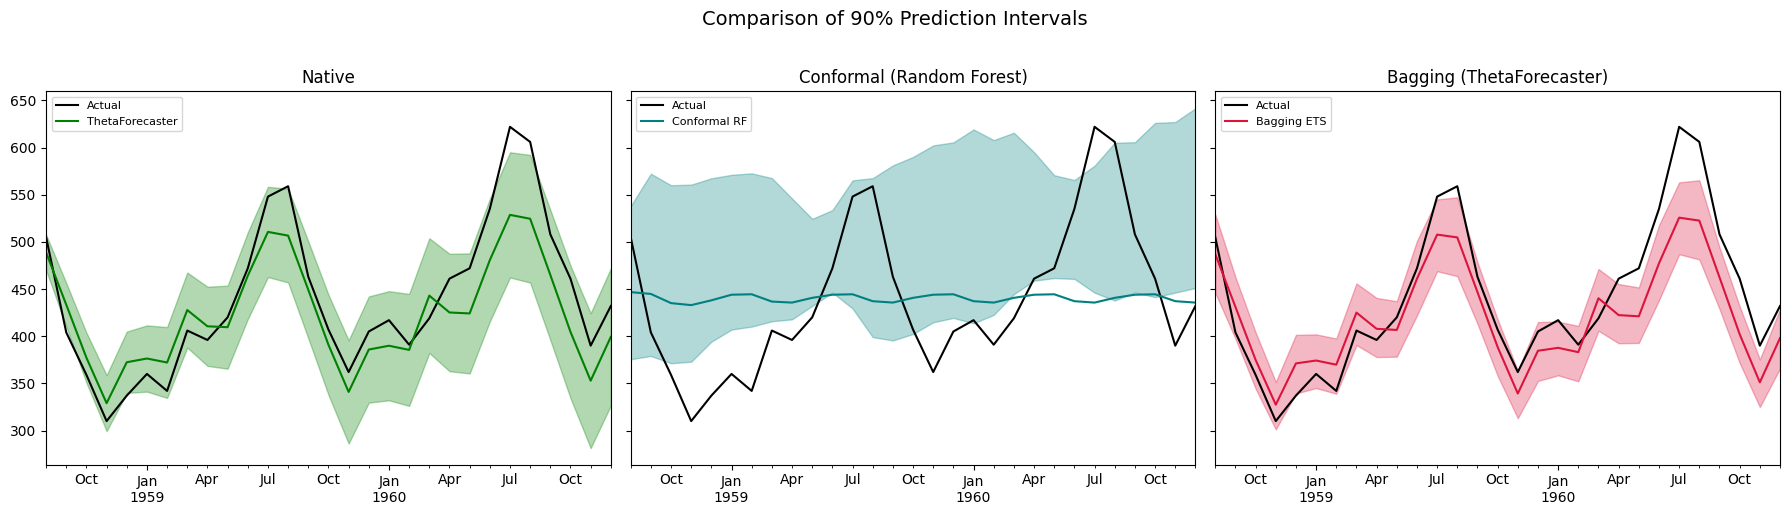

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Native
ax = axes[0]
y_test.plot(ax=ax, label="Actual", color="black")
y_pred.plot(ax=ax, label="ThetaForecaster", color="green")
col_name = y_pred_interval.columns.get_level_values(0)[0]
lo = y_pred_interval[(col_name, 0.9, "lower")]
hi = y_pred_interval[(col_name, 0.9, "upper")]
ax.fill_between(y_pred.index.to_timestamp(), lo, hi, alpha=0.3, color="green")
ax.set_title("Native")
ax.legend(fontsize=8)

# Conformal
ax = axes[1]
y_test.plot(ax=ax, label="Actual", color="black")
y_pred_conf.plot(ax=ax, label="Conformal RF", color="teal")
col_name = y_pred_conf_int.columns.get_level_values(0)[0]
lo = y_pred_conf_int[(col_name, 0.9, "lower")]
hi = y_pred_conf_int[(col_name, 0.9, "upper")]
ax.fill_between(y_pred_conf.index.to_timestamp(), lo, hi, alpha=0.3, color="teal")
ax.set_title("Conformal (Random Forest)")
ax.legend(fontsize=8)

# Bagging
ax = axes[2]
y_test.plot(ax=ax, label="Actual", color="black")
y_pred_bag.plot(ax=ax, label="Bagging ETS", color="crimson")
col_name = y_pred_bag_int.columns.get_level_values(0)[0]
lo = y_pred_bag_int[(col_name, 0.9, "lower")]
hi = y_pred_bag_int[(col_name, 0.9, "upper")]
ax.fill_between(y_pred_bag.index.to_timestamp(), lo, hi, alpha=0.3, color="crimson")
ax.set_title("Bagging (ThetaForecaster)")
ax.legend(fontsize=8)

plt.suptitle("Comparison of 90% Prediction Intervals", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

**Comparison of 90% Prediction Interval Methods:**

| Method | Description | Interval Width | Coverage Quality |
|--------|-------------|---------------|------------------|
| **Native (Theta)** | Built-in parametric intervals from the Theta model | Moderate — captures seasonal variation | Reasonable but may under-cover due to distributional assumptions |
| **Conformal (Random Forest)** | Conformal wrapper on a non-seasonal RF base | Wide but misaligned — intervals are broad yet miss seasonal peaks | Poor — the base forecaster's inability to capture seasonality leads to miscalibrated residuals |
| **Bagging (Theta)** | Bootstrap resampling with Theta forecaster | Narrow — tightly tracks the point forecast | Under-covering — bootstrap captures sampling variability but underestimates total uncertainty |

**Key takeaways:**

1. **Native intervals** (left) are the simplest approach — one model does both point and probabilistic forecasting. The intervals naturally follow the seasonal pattern.
2. **Conformal intervals** (center) can add prediction intervals to *any* forecaster, but their quality depends heavily on the base model. The RandomForest example struggles because it can't model the 12-month seasonality with a short window.
3. **Bagging intervals** (right) produce smooth, data-driven intervals through bootstrap resampling. They capture the seasonal shape well but tend to be too narrow.

In practice, the best method depends on your priorities: **coverage guarantees** (conformal with a good base model), **simplicity** (native), or **model-agnostic uncertainty** (bagging).

## Summary

In this tutorial, we covered the full probabilistic forecasting workflow in `sktime`:

1. **Motivation:** Why point forecasts are not enough — we need uncertainty quantification.
2. **`predict_interval`:** The primary method for obtaining prediction intervals, demonstrated with Exponential Smoothing.
3. **Other methods:** `predict_quantiles` for specific quantile levels, `predict_var` for variance, and `predict_proba` for the full predictive distribution.
4. **Compositions:** Prediction intervals work seamlessly through pipelines and ensembles.
5. **Metrics:** `PinballLoss`, `EmpiricalCoverage`, and `CRPS` for evaluating probabilistic forecasts.
6. **Conformal and Bagging:** Two meta-estimators that can add prediction intervals to *any* forecaster, even those that only produce point forecasts.

For further exploration, consider:
- The **Cross-Validation and Metrics** tutorial for more on model evaluation.
- The **Pipelines** tutorial for more complex composition patterns.
- The **Hyperparameter Tuning** tutorial for optimizing probabilistic forecasters.

---

*For more information, visit the [sktime documentation](https://www.sktime.net/) and the [sktime GitHub repository](https://github.com/sktime/sktime).*

---

## Credits & Metadata

| | |
|---|---|
| **Author** | AffanBasra |
| **Created** | February 2026 |
| **sktime version** | ≥ 1.0.0 |
| **Dataset** | [Airline Passengers](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.datasets.Airline.html) — monthly international airline passengers (1949–1960) |
| **Related issue** | [#8586 — Documentation improvements](https://github.com/sktime/sktime/issues/8586) |
| **License** | [BSD 3-Clause](https://github.com/sktime/sktime/blob/main/LICENSE) (same as sktime) |

**Acknowledgements:** This tutorial was created as part of sktime's documentation improvement initiative ([Enhancement Proposal 25](https://github.com/sktime/enhancement-proposals/blob/main/steps/25_documentation_organization/step.md)). Thanks to the sktime community and maintainers for guidance and review.